In [1]:
import click
import torch
import logging
import random
import math
import numpy as np

from utils.config import Config
from utils.visualization.plot_images_grid import plot_images_grid, show_image
from deepSVDD import DeepSVDD
from datasets.main import load_dataset


## Preparing config & datasets

### Default Setting

In [2]:
load_config = None
nu = 0.01
seed = -1
n_jobs_dataloader = 0
load_model = None
optimizer_name = 'adam'
ae_optimizer_name = 'adam'
device = 'cuda'
apply_model = True


### For CIFAR-10 dataset

In [3]:
# dataset_name = 'cifar10'
# net_name = 'cifar10_LeNet'
# xp_path = '../log/cifar10_test'
# data_path = '../data'
# objective = 'one-class'
# lr = 0.0001
# n_epochs = 150
# lr_milestone = [50]
# batch_size = 200
# weight_decay = 0.5e-6
# pretrain = True
# ae_lr = 0.0001
# ae_n_epochs = 350
# ae_lr_milestone = [250]
# ae_batch_size = 200
# ae_weight_decay = 0.5e-6
# normal_class = 3

### For MNIST dataset

In [4]:
# dataset_name = 'mnist'
# net_name = 'mnist_LeNet'
# xp_path = '../log/mnist_test'
# data_path = '../data'
# objective = 'one-class'
# lr = 0.0001
# n_epochs = 150
# lr_milestone = [50]
# batch_size = 200
# weight_decay = 0.5e-6
# pretrain = True
# ae_lr = 0.0001
# ae_n_epochs = 150
# ae_lr_milestone = [50]
# ae_batch_size = 200
# ae_weight_decay = 0.5e-3
# normal_class = 3

In [5]:
dataset_name = 'custom'
net_name = 'mnist_LeNet'
xp_path = '../log/custom'
data_path = '../data'
objective = 'one-class'
lr = 0.0001
n_epochs = 150
lr_milestone = [50]
batch_size = 200
weight_decay = 0.5e-6
pretrain = True
ae_lr = 0.0001
ae_n_epochs = 150
ae_lr_milestone = [50]
ae_batch_size = 200
ae_weight_decay = 0.5e-3
normal_class = 3

## Load Config

In [6]:

# Get configuration
cfg = Config(locals().copy())

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_file = xp_path + '/log.txt'
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)


## Add Logs

In [7]:

# Print arguments
logger.info('Log file is %s.' % log_file)
logger.info('Data path is %s.' % data_path)
logger.info('Export path is %s.' % xp_path)

logger.info('Dataset: %s' % dataset_name)
logger.info('Normal class: %d' % normal_class)
logger.info('Network: %s' % net_name)

# If specified, load experiment config from JSON-file
if load_config:
    cfg.load_config(import_json=load_config)
    logger.info('Loaded configuration from %s.' % load_config)

# Print configuration
logger.info('Deep SVDD objective: %s' % cfg.settings['objective'])
logger.info('Nu-paramerter: %.2f' % cfg.settings['nu'])

# Set seed
if cfg.settings['seed'] != -1:
    random.seed(cfg.settings['seed'])
    np.random.seed(cfg.settings['seed'])
    torch.manual_seed(cfg.settings['seed'])
    logger.info('Set seed to %d.' % cfg.settings['seed'])

# Default device to 'cpu' if cuda is not available
if not torch.cuda.is_available():
    device = 'cpu'
logger.info('Computation device: %s' % device)
logger.info('Number of dataloader workers: %d' % n_jobs_dataloader)

INFO:root:Log file is ../log/custom/log.txt.
INFO:root:Data path is ../data.
INFO:root:Export path is ../log/custom.
INFO:root:Dataset: custom
INFO:root:Normal class: 3
INFO:root:Network: mnist_LeNet
INFO:root:Deep SVDD objective: one-class
INFO:root:Nu-paramerter: 0.01
INFO:root:Computation device: cpu
INFO:root:Number of dataloader workers: 0


## Load Datasets

In [ ]:
# Load data
dataset = load_dataset(dataset_name, data_path, normal_class)

In [9]:
dataset.train_set.dataset[0][0].shape

torch.Size([1, 28, 28])

In [10]:
dataset.train_set

In [11]:
len(dataset.train_set)

76

In [12]:
np.hstack(dataset.train_set.indices)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75])

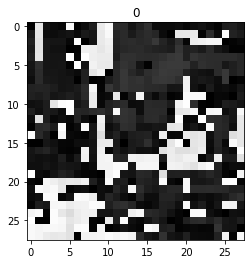

In [13]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
idx_no = 70
transform = transforms.ToPILImage()
plt.title(dataset.train_set.dataset[idx_no][1])
plt.imshow(transform(dataset.train_set.dataset[idx_no][0]), cmap='gray', vmin=0, vmax=255)

## Setup model and network

In [14]:
# Initialize DeepSVDD model and set neural network \phi
deep_SVDD = DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
deep_SVDD.set_network(net_name)

In [15]:
# If specified, load Deep SVDD model (radius R, center c, network weights, and possibly autoencoder weights)
if load_model:
    deep_SVDD.load_model(model_path=load_model, load_ae=True)
    logger.info('Loading model from %s.' % load_model)

logger.info('Pretraining: %s' % pretrain)

INFO:root:Pretraining: True


### [Optional] Using Pre-Trained

In [16]:

logger.info('Pretraining: %s' % pretrain)
if pretrain:
    # Log pretraining details
    logger.info('Pretraining optimizer: %s' % cfg.settings['ae_optimizer_name'])
    logger.info('Pretraining learning rate: %g' % cfg.settings['ae_lr'])
    logger.info('Pretraining epochs: %d' % cfg.settings['ae_n_epochs'])
    logger.info('Pretraining learning rate scheduler milestones: %s' % (cfg.settings['ae_lr_milestone'],))
    logger.info('Pretraining batch size: %d' % cfg.settings['ae_batch_size'])
    logger.info('Pretraining weight decay: %g' % cfg.settings['ae_weight_decay'])

    # Pretrain model on dataset (via autoencoder)
    deep_SVDD.pretrain(dataset,
                        optimizer_name=cfg.settings['ae_optimizer_name'],
                        lr=cfg.settings['ae_lr'],
                        n_epochs=cfg.settings['ae_n_epochs'],
                        lr_milestones=cfg.settings['ae_lr_milestone'],
                        batch_size=cfg.settings['ae_batch_size'],
                        weight_decay=cfg.settings['ae_weight_decay'],
                        device=device,
                        n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Pretraining: True
INFO:root:Pretraining optimizer: adam
INFO:root:Pretraining learning rate: 0.0001
INFO:root:Pretraining epochs: 150
INFO:root:Pretraining learning rate scheduler milestones: [50]
INFO:root:Pretraining batch size: 200
INFO:root:Pretraining weight decay: 0.0005
INFO:root:Starting pretraining...
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/150	 Time: 0.098	 Loss: 134.38822937
INFO:root:  Epoch 2/150	 Time: 

In [17]:

# Log training details
logger.info('Training optimizer: %s' % cfg.settings['optimizer_name'])
logger.info('Training learning rate: %g' % cfg.settings['lr'])
logger.info('Training epochs: %d' % cfg.settings['n_epochs'])
logger.info('Training learning rate scheduler milestones: %s' % (cfg.settings['lr_milestone'],))
logger.info('Training batch size: %d' % cfg.settings['batch_size'])
logger.info('Training weight decay: %g' % cfg.settings['weight_decay'])


INFO:root:Training optimizer: adam
INFO:root:Training learning rate: 0.0001
INFO:root:Training epochs: 150
INFO:root:Training learning rate scheduler milestones: [50]
INFO:root:Training batch size: 200
INFO:root:Training weight decay: 5e-07


## Train model

In [18]:
# Train model on dataset
deep_SVDD.train(dataset,
                optimizer_name=cfg.settings['optimizer_name'],
                lr=cfg.settings['lr'],
                n_epochs=cfg.settings['n_epochs'],
                lr_milestones=cfg.settings['lr_milestone'],
                batch_size=cfg.settings['batch_size'],
                weight_decay=cfg.settings['weight_decay'],
                device=device,
                n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Initializing center c...
INFO:root:Center c initialized.
INFO:root:Starting training...
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:root:  Epoch 1/150	 Time: 0.046	 Loss: 2.91983056
INFO:root:  Epoch 2/150	 Time: 0.040	 Loss: 2.83327031
INFO:root:  Epoch 3/150	 Time: 0.036	 Loss: 2.75456834
INFO:root:  Epoch 4/150	 Time: 0.038	 Loss: 2.68134212
INFO:root:  Epoch 5/150	 Time: 0.037	 Loss: 2.61239862
INFO:root:  Epoch 6/150	 Time: 0.036	

## Evaluate

In [20]:
deep_SVDD.test(dataset, device=device, n_jobs_dataloader=n_jobs_dataloader)

INFO:root:Starting testing...
INFO:root:Testing time: 0.004
INFO:root:Test set AUC: 100.00%
INFO:root:Finished testing.


In [21]:
# Plot most anomalous and most normal (within-class) test samples
indices, labels, scores = zip(*deep_SVDD.results['test_scores'])
indices, labels, scores = np.array(indices), np.array(labels), np.array(scores)
idx_sorted = indices[labels == 0][np.argsort(scores[labels == 0])]  # sorted from lowest to highest anomaly score


In [22]:
scores

array([0.83345801, 1.32908773, 0.22859728, 0.20104563, 0.22859728,
       1.12149811])

In [23]:
# Scoring index sorting by score value (low -> high)
score_idx = np.argsort(scores)

array([0, 5, 1])

In [ ]:
if dataset_name in ('mnist', 'cifar10', 'custom'):

    if dataset_name == 'mnist':
        X_normals = dataset.test_set.test_data[idx_sorted[:32], ...].unsqueeze(1)
        X_outliers = dataset.test_set.test_data[idx_sorted[-32:], ...].unsqueeze(1)
        plot_images_grid(X_normals, export_img=xp_path + '/normals', title='Most normal examples', padding=2)
        plot_images_grid(X_outliers, export_img=xp_path + '/outliers', title='Most anomalous examples', padding=2)

    if dataset_name == 'cifar10':
        X_normals = torch.tensor(np.transpose(dataset.test_set.test_data[idx_sorted[:32], ...], (0, 3, 1, 2)))
        X_outliers = torch.tensor(np.transpose(dataset.test_set.test_data[idx_sorted[-32:], ...], (0, 3, 1, 2)))
        plot_images_grid(X_normals, export_img=xp_path + '/normals', title='Most normal examples', padding=2)
        plot_images_grid(X_outliers, export_img=xp_path + '/outliers', title='Most anomalous examples', padding=2)

    if dataset_name == 'custom':
#         X_normals = dataset.test_set.test_data[0][idx_sorted[:32], ...].unsqueeze(1)
#         X_outliers = dataset.test_set.test_data[0][idx_sorted[-32:], ...].unsqueeze(1)
        X_normals = torch.tensor(dataset.test_set.test_data)[idx_sorted[:32], ...][0]
        X_outliers = torch.tensor(dataset.test_set.test_data)[idx_sorted[-32:], ...][0]
        
        normal_idx = score_idx[-math.ceil(len(score_idx)/2):]
        outliers_idx = score_idx[:math.ceil(len(score_idx)/2)]
        print('Normal:')
        show_image(normal_idx, dataset.test_set.test_data, labels, export_img=xp_path + '/normals')
        print('Abnormal:')
        show_image(outliers_idx, dataset.test_set.test_data, labels, export_img=xp_path + '/outliers')
        


In [25]:
len(dataset.test_set.test_data)

6

In [26]:
indices, labels, scores

(array([0, 1, 2, 3, 4, 5]),
 array([1, 1, 0, 0, 0, 1]),
 array([0.83345801, 1.32908773, 0.22859728, 0.20104563, 0.22859728,
        1.12149811]))

## Save model

In [27]:
# Save results, model, and configuration
deep_SVDD.save_results(export_json=xp_path + '/results.json')
deep_SVDD.save_model(export_model=xp_path + '/model.tar')
cfg.save_config(export_json=xp_path + '/config.json')

TypeError: Object of type module is not JSON serializable

In [ ]:
# Apply model and print to file
if apply_model:
    deep_SVDD.apply_model(export_file=xp_path + '/apply_output.txt', dataset=dataset, device=device, n_jobs_dataloader=n_jobs_dataloader)
